# Neural Nets: The Devil's in the Details

Seth Weidman    

06/02/2017

# Neural Nets: WTF is going on??

<img src='img/neural_net_wtf.png' height=200>

What does this actually mean?

## Review from last time (Pt. 1)

* Neural nets are nested functions, where the functions applied to the inputs alternate between two types:
    * Linear functions, represented by matrix multiplications
    * Non linear "activation" functions
* Because they are functions, we can represent the neural net making a prediction mathematically. For example, if $X$ is the input, then the prediction $P$ is just: 

$$ P = A(B(C(D(X, V)), W)) $$

where $A$, $B$, $C$, and $D$ are functions and $V$ and $W$ are weight matrices.

## Review from last time (Pt. 2)

* This prediction is compared to the actual value we were trying to predict, $Y$, and a loss is computed, for example:

$$ L = (Y - P) ^ 2 $$

* And then the weights are adjusted so that this loss will be reduced:

$$ W = W - \frac{\partial L}{\partial W}$$

$$ V = V - \frac{\partial L}{\partial V}$$

## Key point from last time

* This process - of computing derivatives to continually update the weights in a neural net - works because of **the chain rule from calculus**.

## We can do basic neural nets!

<img src="img/neural_net_check.png">

We got this.

# This basic neural net framework can learn MNIST

**This basic neural net framework can learn MNIST**

## Pt. 1: Imports

In [239]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
import numpy as np
from sklearn.model_selection import train_test_split

**This basic neural net framework can learn MNIST**

## Pt. 2: Read in the MNIST Data

In [240]:
## Read in the MNIST Data

mnist = fetch_mldata('MNIST original') 

In [241]:
def get_mnist_X_Y(mnist):
    data = mnist.data
    X = (data - data.min()) * 1.0 / (data.max() - data.min())
    target = mnist.target
    Y = np.zeros((len(target), 10))
    for i in range(len(target)):
        Y[i][int(target[i])] = 1 
    print("Number of images: ", X.shape[0])
    return X, Y

In [242]:
X, Y = get_mnist_X_Y(mnist)

Number of images:  70000


In [243]:
train_prop = 0.9
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=1-train_prop, 
    random_state=1)

**This basic neural net framework can learn MNIST**

## Pt. 3: Visualize the Images

In [244]:
def visualize_image(index):
    target = mnist.target
    print("Label: ", int(target[index]))
    plt.imshow(1.0 - X[index].reshape(28,28), cmap='gray')
    plt.show() 

Label:  0


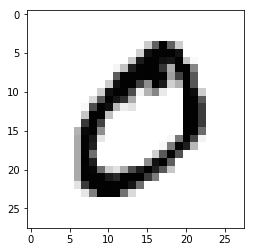

In [245]:
visualize_image(0)

**This basic neural net framework can learn MNIST**

## Pt. 4: Train the neural net

In [246]:
def _sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

In [247]:
def learn(X, Y, num_iter):
    np.random.seed(2)
    V = np.random.randn(784, 50)
    W = np.random.randn(50, 10)
    for j in range(num_iter):
        i = np.random.randint(0, num_iter)
        x = np.array(X[i], ndmin=2)
        y = np.array(Y[i], ndmin=2)
        A = np.dot(x,V)
        B = _sigmoid(A)
        C = np.dot(B,W)
        P = _sigmoid(C)
        sum_P = np.sum(P)
        L = 0.5 * (y - P) ** 2
        dLdP = -1.0 * (y-P)
        dPdC = _sigmoid(C) * (1-_sigmoid(C))
        dLdC = dLdP * dPdC
        dCdW = B.T
        dLdW = np.dot(dCdW, dLdC)
        dCdB = W.T
        dLdB = np.dot(dLdC, dCdB)
        dBdA = _sigmoid(A) * (1-_sigmoid(A))
        dLdA = dLdB * dBdA
        dAdV = x.T
        dLdV = np.dot(dAdV, dLdA)
        W -= dLdW
        V -= dLdV
    return V, W  

In [248]:
  def predict(X, V, W):
    A = np.dot(X,V)
    B = _sigmoid(A)
    C = np.dot(B,W)
    P = _sigmoid(C)
    return P

In [249]:
V, W = learn(X_train, Y_train, num_iter=X_train.shape[0])
P = predict(X_test, V, W)

In [250]:
preds = [np.argmax(x) for x in P]
actuals = [np.argmax(x) for x in Y_test]

accuracy = sum(np.array(preds) == np.array(actuals)) * 1.0 / len(preds)
print("Neural Net MNIST Classification Accuracy:", round(accuracy, 3) * 100, "percent")

Neural Net MNIST Classification Accuracy: 91.3 percent


91.3% accuracy. Good...

...but not optimal: [see here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

<img src='img/MNIST_performance.png' height=200>

# How can we do better?

## How can we do better?

* Building deeper nets
* Changing "learning rates" / using "learning rate decay"
* Adding "dropout"
* ...and that doesn't even cover many of the cutting edge techniques listed above

Are you overwhelmed yet?

## Paradox of choice

<img src="supermarket.png">

Neural nets are really hard to unpack and understand - so much so that a lot of people don't even try.

**By "playing with these knobs" individually - as well as learning a bit of theory, we can "peek under the hood" and understand how to make our neural nets work better.**

# Multiple hidden layers ("Deep Learning")

**"What I cannot build, I cannot understand."**

--Richard Feynman

## Before:

With a neural net with one hidden layer, one pass through was 25 manually coded steps. 

_This will quickly get unweildy if we add more hidden layers._

## New understanding: "Layers"

No longer will we think of neural nets as complicated mathematical functions like $ P = A(B(C(D(X, V)), W)) $.

### New understanding: "Layers"

Instead, we'll think of them as a series of layers:

<img src='img/neural_net_layers.png' height=200>

## Coding the new neural network, layers

We'll define a `NeuralNetwork` class that defines a neural network as a series of `Layers`:

In [251]:
class NeuralNetwork(object):
    def __init__(self, layers, random_seed):
        self.layers = layers
        self.random_seed = random_seed
        for i, layer in enumerate(self.layers):
            setattr(layer, 'random_seed', self.random_seed+i)
            layer.initialize_weights()


    def forwardpass(self, X):
        """ Calculate an output Y for the given input X. """
        X_next = X
        for layer in self.layers:
            X_next = layer.fprop(X_next)
        prediction = X_next
        return prediction

    def loss(self, prediction, Y):
        """ Calculate error on the given data. """
        loss = 0.5 * (Y - prediction) ** 2
        return -1.0 * (Y - prediction)

    def backpropogate(self, loss):
        """ Calculate an output Y for the given input X. """
        loss_next = loss
        for layer in reversed(self.layers):
            loss_next = layer.bprop(loss_next)
        return loss

### Coding the new neural network, layers

In [252]:
class Layer(object):
    def _setup(self, input_shape):
        """ Setup layer with parameters that are unknown at __init__(). """
        pass

    def fprop(self, input):
        """ Calculate layer output for given input (forward propagation). """
        raise NotImplementedError()

    def bprop(self, output_grad):
        """ Calculate input gradient. """
        raise NotImplementedError()

## Props

<img src="img/andersbll.png">

[Anders' GitHub](https://github.com/andersbll)

### Coding the new neural network, layers

In [254]:
class Linear(Layer):
    
    random_seed = None
    
    def __init__(self, n_in, n_out, 
                 activation_function):
        self.n_in = n_in
        self.n_out = n_out        
        self.iteration = 0
        self.activation_function = activation_function

    def initialize_weights(self):
        np.random.seed(seed=self.random_seed)
        self.W = np.random.normal(size=(self.n_in, self.n_out))

    def fprop(self, layer_input):
        self.layer_input = layer_input
        self.activation_input = np.dot(layer_input, self.W)
        return self.activation_function(self.activation_input, bprop=False)

    def bprop(self, layer_gradient):
        dOutdActivationInput = self.activation_function(self.activation_input, bprop=True)
        dLayerInputdActivationInput = layer_gradient * dOutdActivationInput
        dActivationOutputdActivationInput = self.layer_input.T
        output_grad = np.dot(dLayerInputdActivationInput, self.W.T)
        weight_update = np.dot(dActivationOutputdActivationInput, dLayerInputdActivationInput)
        W_new = self.W - weight_update
        self.W = W_new
        self.iteration += 1
        return output_grad

### Coding the new neural network, layers - and don't forget about that activation function!

In [255]:
def sigmoid(x, bprop=False):
    if bprop:
        s = sigmoid(x)
        return s*(1-s)
    else:
        return 1.0/(1.0+np.exp(-x))

## Running this neural network:

In [256]:
layer1 = Linear(n_in=784, n_out=50, activation_function=sigmoid)
layer2 = Linear(n_in=50, n_out=10, activation_function=sigmoid)

In [257]:
nn_mnist = NeuralNetwork(
    layers=[layer1, layer2],
    random_seed=2)

In [258]:
def neural_net_pass(net, x, y):
    pred = net.forwardpass(x)
    loss = net.loss(pred, y)
    net.backpropogate(loss)
    return pred

### Running this neural network

In [259]:
# Randomly shuffle the indices of the points in the training set:
np.random.seed(4)
train_size = X_train.shape[0]
indices = list(range(train_size))
np.random.shuffle(indices)

In [260]:
# Loop through every element in the training set: 
for index in indices:
    x = np.array(X_train[index], ndmin=2)
    y = np.array(Y_train[index], ndmin=2)
    neural_net_pass(nn_mnist, x, y)

In [261]:
P = nn_mnist.forwardpass(X_test)
preds = [np.argmax(x) for x in P]
actuals = [np.argmax(x) for x in Y_test]

accuracy = sum(np.array(preds) == np.array(actuals)) * 1.0 / len(preds)
print("Neural Net MNIST Classification Accuracy:", round(accuracy, 3) * 100, "percent")

Neural Net MNIST Classification Accuracy: 82.3 percent


A different random weight initialization gave us just 82.3% accuracy this time.

### Running this neural network

#### Turning what we did above into a function

In [262]:
def train_test_net(net, X_train, Y_train, X_test, Y_test, random_seed):

    # Randomly set the seed
    np.random.seed(random_seed)
    
    # Randomly shuffle the indices of the points in the training set:
    train_size = X_train.shape[0]
    indices = list(range(train_size))
    np.random.shuffle(indices)
    
    # Loop through every element in the training set: 
    for index in indices:
        x = np.array(X_train[index], ndmin=2)
        y = np.array(Y_train[index], ndmin=2)
        neural_net_pass(net, x, y)
        
    P = net.forwardpass(X_test)
    preds = [np.argmax(x) for x in P]
    actuals = [np.argmax(x) for x in Y_test]

    accuracy = sum(np.array(preds) == np.array(actuals)) * 1.0 / len(preds)

    return accuracy

# Deeper networks



Now that we've built a framework allowing us to define networks as a series of layers, we can easily build deeper networks.

In [263]:
input_layer = Linear(n_in=784, n_out=50, activation_function=sigmoid)
hidden_1 = Linear(n_in=50, n_out=50, activation_function=sigmoid)
hidden_2 = Linear(n_in=50, n_out=50, activation_function=sigmoid)
hidden_3 = Linear(n_in=50, n_out=50, activation_function=sigmoid)
output_layer = Linear(n_in=50, n_out=10, activation_function=sigmoid)

In [264]:
def print_accuracy_net_layers(layers):
    # Define net
    net = NeuralNetwork(
        layers=layers,
        random_seed=2)

    accuracy_one_hidden = train_test_net(net, X_train, Y_train, X_test, Y_test, 4)
    
    return accuracy_one_hidden

## Deeper networks

In [265]:
accuracy = print_accuracy_net_layers([input_layer, 
                                      output_layer])
print("The accuracy of a network with one hidden layer was", np.round(accuracy * 100.0, 1))

The accuracy of a network with one hidden layer was 82.3


In [266]:
accuracy = print_accuracy_net_layers([input_layer, 
                                      hidden_1, 
                                      output_layer])
print("The accuracy of a network with two hidden layers was", np.round(accuracy * 100.0, 1))

The accuracy of a network with two hidden layers was 90.7


In [267]:
accuracy = print_accuracy_net_layers([input_layer, 
                                      hidden_1, 
                                      hidden_2,
                                      output_layer])
print("The accuracy of a network with three hidden layers was", np.round(accuracy * 100.0, 1))

The accuracy of a network with three hidden layers was 88.0


In [268]:
accuracy = print_accuracy_net_layers([input_layer, 
                                      hidden_1, 
                                      hidden_2,
                                      hidden_3,
                                      output_layer])
print("The accuracy of a network with four hidden layers was", np.round(accuracy * 100.0, 1))

The accuracy of a network with four hidden layers was 87.7


**"Deep Learning" can help, but we need more "tricks" to really get these things working.**

# Learning rate tuning

<img src="img/bengio.png">

"The learning rate is the single most important hyperparameter and one should always make sure it is tuned."

-[Yoshua Bengio](http://www.iro.umontreal.ca/~bengioy/yoshua_en/)

$$ W =  W - \alpha * \frac{\partial l}{\partial W}$$

## Learning rate tuning

In [269]:
class NeuralNetwork(object):
    def __init__(self, layers, random_seed, learning_rate):
        self.layers = layers
        self.random_seed = random_seed
        self.learning_rate = learning_rate
        for i, layer in enumerate(self.layers):
            setattr(layer, 'random_seed', self.random_seed+i)
            setattr(layer, 'learning_rate', self.learning_rate)
            layer.initialize_weights()


    def forwardpass(self, X):
        """ Calculate an output Y for the given input X. """
        X_next = X
        for layer in self.layers:
            X_next = layer.fprop(X_next)
        prediction = X_next
        return prediction

    def loss(self, prediction, Y):
        """ Calculate error on the given data. """
        loss = 0.5 * (Y - prediction) ** 2
        return -1.0 * (Y - prediction)

    def backpropogate(self, loss):
        """ Calculate an output Y for the given input X. """
        loss_next = loss
        for layer in reversed(self.layers):
            loss_next = layer.bprop(loss_next)
        return loss

## Learning rate tuning

In [270]:
class Linear(Layer):
    
    random_seed = None
    learning_rate = None
    
    def __init__(self, n_in, n_out, 
                 activation_function):
        self.n_in = n_in
        self.n_out = n_out        
        self.iteration = 0
        self.activation_function = activation_function

    def initialize_weights(self):
        np.random.seed(seed=self.random_seed)
        self.W = np.random.normal(size=(self.n_in, self.n_out))

    def fprop(self, layer_input):
        self.layer_input = layer_input
        self.activation_input = np.dot(layer_input, self.W)
        return self.activation_function(self.activation_input, bprop=False)

    def bprop(self, layer_gradient):
        dOutdActivationInput = self.activation_function(self.activation_input, bprop=True)
        dLayerInputdActivationInput = layer_gradient * dOutdActivationInput
        dActivationOutputdActivationInput = self.layer_input.T
        output_grad = np.dot(dLayerInputdActivationInput, self.W.T)
        weight_update = np.dot(dActivationOutputdActivationInput, dLayerInputdActivationInput)
        W_new = self.W - self.learning_rate * weight_update
        self.W = W_new
        self.iteration += 1
        return output_grad

## Learning rate tuning

In [271]:
input_layer = Linear(n_in=784, n_out=50, activation_function=sigmoid)
hidden_1 = Linear(n_in=50, n_out=50, activation_function=sigmoid)
output_layer = Linear(n_in=50, n_out=10, activation_function=sigmoid)

In [272]:
def learning_rate_accuracy(learning_rate):
    
    net = NeuralNetwork(
        layers = [input_layer, hidden_1, output_layer],
        random_seed = 2,
        learning_rate = learning_rate
    )
    
    accuracy_lr = train_test_net(net, X_train, Y_train, X_test, Y_test, 4)
    print("The accuracy of a network with learning rate", learning_rate, "was", np.round(accuracy_lr * 100.0, 1))

    return accuracy_lr

In [34]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 10]
lr_accuracies = [learning_rate_accuracy(x) for x in learning_rates]

The accuracy of a network with learning rate 0.0001 was 9.7
The accuracy of a network with learning rate 0.001 was 18.1
The accuracy of a network with learning rate 0.01 was 68.6
The accuracy of a network with learning rate 0.1 was 89.8
The accuracy of a network with learning rate 1 was 90.7
The accuracy of a network with learning rate 10 was 17.9


# Learning rate tuning: getting fancy

Because backpropogation involves multiplying a value by the derivative of the activation function, gradients (that tell the weights how to update) get smaller and smaller as you go get further from the output layer:

<img src="img/sigmoid_deriv_trask.png">
**At most, the gradient can be multiplied by 0.25 at each layer.** More [here](http://iamtrask.github.io/2015/07/12/basic-python-network/)

## Learning rate tuning: getting fancy

In [273]:
class NeuralNetwork(object):
    def __init__(self, layers, 
                 random_seed, 
                 learning_rate):
        self.layers = layers
        self.random_seed = random_seed
        self.learning_rate = learning_rate
        for i, layer in enumerate(self.layers):
            setattr(layer, 'random_seed', self.random_seed+i)
            setattr(layer, 'learning_rate', 
                    self.learning_rate/(10.0 ** i))
            layer.initialize_weights()

    def forwardpass(self, X):
        """ Calculate an output Y for the given input X. """
        X_next = X
        for layer in self.layers:
            X_next = layer.fprop(X_next)
        prediction = X_next
        return prediction

    def loss(self, prediction, Y):
        """ Calculate error on the given data. """
        loss = 0.5 * (Y - prediction) ** 2
        return -1.0 * (Y - prediction)

    def backpropogate(self, loss):
        """ Calculate an output Y for the given input X. """
        loss_next = loss
        for layer in reversed(self.layers):
            loss_next = layer.bprop(loss_next)
        return loss

## Learning rate tuning: getting fancy

In [36]:
input_layer = Linear(n_in=784, n_out=50, activation_function=sigmoid)
hidden_1 = Linear(n_in=50, n_out=50, activation_function=sigmoid)
output_layer = Linear(n_in=50, n_out=10, activation_function=sigmoid)

In [37]:
def learning_rate_accuracy(learning_rate):
    
    net = NeuralNetwork(
        layers = [input_layer, hidden_1, output_layer],
        random_seed = 2,
        learning_rate = learning_rate
    )
    
    accuracy_lr = train_test_net(net, X_train, Y_train, X_test, Y_test, 4)
    
    print("The accuracy of a network with learning rate \n", learning_rate,
          "in the first layer \n", learning_rate / 10.0,
          "in the second layer, and \n", learning_rate / 100.0, 
          "in the third layer is", 
          np.round(accuracy_lr * 100.0, 1), "percent")

    return accuracy_lr

## Learning rate tuning: getting fancy

In [38]:
learning_rates = [0.01, 0.1, 1, 10]
lr_accuracies = [learning_rate_accuracy(x) for x in learning_rates]

The accuracy of a network with learning rate 
 0.01 in the first layer 
 0.001 in the second layer, and 
 0.0001 in the third layer is 9.7 percent
The accuracy of a network with learning rate 
 0.1 in the first layer 
 0.01 in the second layer, and 
 0.001 in the third layer is 83.2 percent
The accuracy of a network with learning rate 
 1 in the first layer 
 0.1 in the second layer, and 
 0.01 in the third layer is 91.8 percent
The accuracy of a network with learning rate 
 10 in the first layer 
 1.0 in the second layer, and 
 0.1 in the third layer is 84.3 percent


The accuracy is up to 91.8%, up from 90.7% before. We could also view that as roughly a 10% reduction in error rate. 

**Having a higher learning rate in earlier layers vs. later layers does help accuracy.** 

# Learning rate momentum

The weights in a neural net are updated according to:

$$ W =  W - \frac{\partial L}{\partial W}$$

Recall that this is equivalent to doing gradient descent with each parameter:

<img src="img/gradient_descent.png">

This is analogous to a ball rolling down a hill. 

Balls rolling down hills have momentum. So, therefore, should our weights!

## Learning rate momentum

Let's define our weight update $ \frac{\partial L}{\partial W} $ to be $ U_t $. Then, instead of our weight update being $ U_t $ at each time step, it will be:

$$ U_t + \mu * U_{t-1} + \mu^2 * U_{t-2} + ... $$ 

where $\mu$ is a decay parameter between 0 and 1.

This is equivalent to, and often described as, increasing your learning rate when your weight updates are going in the same direction, iteration after iteration, and lowering your learning rate when the opposite is happening.

## Implementing learning rate momentum

In [276]:
class Linear(Layer):
    
    random_seed = None
    learning_rate = None
    momentum = None
    
    def __init__(self, n_in, n_out, 
                 activation_function):
        self.n_in = n_in
        self.n_out = n_out        
        self.iteration = None
        self.activation_function = activation_function
        self.velocity = None

    def initialize_weights(self):
        np.random.seed(seed=self.random_seed)
        self.W = np.random.normal(size=(self.n_in, self.n_out))
        self.velocity = np.zeros(shape=(self.n_in, self.n_out))

    def fprop(self, layer_input):
        self.layer_input = layer_input
        self.activation_input = np.dot(layer_input, self.W)
        return self.activation_function(self.activation_input, bprop=False)

    def bprop(self, layer_gradient):
        dOutdActivationInput = self.activation_function(self.activation_input, 
                                                        bprop=True)
        dLayerInputdActivationInput = layer_gradient * dOutdActivationInput
        dActivationOutputdActivationInput = self.layer_input.T
        output_grad = np.dot(dLayerInputdActivationInput, self.W.T)
        
        # Update velocity
        weight_update_current = np.dot(dActivationOutputdActivationInput, 
                                       dLayerInputdActivationInput)
        self.velocity = np.add(self.momentum * self.velocity, 
                               self.learning_rate * weight_update_current)
        self.W = self.W - self.velocity
        return output_grad

## Implementing learning rate momentum

In [278]:
class NeuralNetwork(object):
    def __init__(self, layers, random_seed, learning_rate, momentum):
        self.layers = layers
        self.random_seed = random_seed
        self.momentum = momentum
        self.learning_rate = learning_rate
        for i, layer in enumerate(self.layers):
            setattr(layer, 'random_seed', self.random_seed+i)
            layer.initialize_weights()
            setattr(layer, 'learning_rate', self.learning_rate/(10.0 ** i))
            setattr(layer, 'momentum', self.momentum)

    def forwardpass(self, X):
        """ Calculate an output Y for the given input X. """
        X_next = X
        for layer in self.layers:
            X_next = layer.fprop(X_next)
        prediction = X_next
        return prediction

    def loss(self, prediction, Y):
        """ Calculate error on the given data. """
        loss = 0.5 * (Y - prediction) ** 2
        return -1.0 * (Y - prediction)

    def backpropogate(self, loss):
        """ Calculate an output Y for the given input X. """
        loss_next = loss
        for layer in reversed(self.layers):
            loss_next = layer.bprop(loss_next)
        return loss

## Implementing learning rate momentum

In [41]:
input_layer = Linear(n_in=784, n_out=50, activation_function=sigmoid)
hidden_1 = Linear(n_in=50, n_out=50, activation_function=sigmoid)
output_layer = Linear(n_in=50, n_out=10, activation_function=sigmoid)

In [42]:
def learning_rate_accuracy(learning_rate, momentum):
    
    net = NeuralNetwork(
        layers = [input_layer, hidden_1, output_layer],
        random_seed = 2,
        learning_rate = learning_rate,
        momentum = momentum
    )
    
    accuracy_lr = train_test_net(net, X_train, Y_train, X_test, Y_test, 4)
    
    print("The accuracy of a network with learning rate \n", learning_rate,
          "in the first layer \n", learning_rate / 10.0,
          "in the second layer, and \n", learning_rate / 100.0, 
          "in the third layer, and \n momentum", momentum, "is",
          np.round(accuracy_lr * 100.0, 1), "percent")

    return accuracy_lr

## Learning rate momentum results

In [43]:
learning_rates = [1]
momentum = [0.5, 0.75, 0.9]
for learning_rate in learning_rates:
    for m in momentum:
        learning_rate_accuracy(learning_rate, m)

The accuracy of a network with learning rate 
 1 in the first layer 
 0.1 in the second layer, and 
 0.01 in the third layer, and 
 momentum 0.5 is 92.0 percent
The accuracy of a network with learning rate 
 1 in the first layer 
 0.1 in the second layer, and 
 0.01 in the third layer, and 
 momentum 0.75 is 90.2 percent
The accuracy of a network with learning rate 
 1 in the first layer 
 0.1 in the second layer, and 
 0.01 in the third layer, and 
 momentum 0.9 is 84.6 percent


Here, we get a practical lesson: **throwing the "kitchen sink" of neural net tricks at a problem in unnecessary at best and actually harmful at worst.** 

Indeed, learning rate momentum has been shown to work on Recurrent Neural Nets, not fully connected neural nets as we have here. See 
[Bengio et. al. (2014)](https://arxiv.org/pdf/1212.0901v2.pdf).

# Dropout

Dropout can help prevent neural networks from overfitting. It involves "dropping" a portion of the neurons - that is, setting their values to zero - on each forward pass through the network. 

<img src="img/dropout.png">

This nudges the network toward learning "redundant representations of its data".

## Dropout

In [285]:
class NeuralNetworkDropout(object):
    def __init__(self, layers, random_seed, 
                 learning_rate, momentum, dropout):
        self.layers = layers
        self.random_seed = random_seed
        self.momentum = momentum
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.iteration = 0
        for i, layer in enumerate(self.layers):
            setattr(layer, 'random_seed', self.random_seed+i)
            layer.initialize_weights()
            setattr(layer, 'learning_rate', self.learning_rate/(10.0 ** i))
            setattr(layer, 'momentum', self.momentum)

    def forwardpass(self, X):
        """ Calculate an output Y for the given input X. """
        X_next = X
        for i, layer in enumerate(self.layers):
            np.random.seed(seed=self.random_seed+i*self.iteration)
            if self.dropout:
                zero_indices = np.random.choice(range(layer.n_in), 
                                                size=int(layer.n_in * (1 - self.dropout)), 
                                                replace=False)
                X_next[:, zero_indices] = 0.0
            X_next = layer.fprop(X_next)
        prediction = X_next
        self.iteration += 1
        return prediction

    def loss(self, prediction, Y):
        """ Calculate error on the given data. """
        loss = 0.5 * (Y - prediction) ** 2
        return -1.0 * (Y - prediction)

    def backpropogate(self, loss):
        """ Calculate an output Y for the given input X. """
        loss_next = loss
        for layer in reversed(self.layers):
            loss_next = layer.bprop(loss_next)
        return loss

## Dropout

In [286]:
def train_test_net_dropout(net, X_train, Y_train, X_test, Y_test, random_seed):

    # Randomly set the seed
    np.random.seed(random_seed)
    
    # Randomly shuffle the indices of the points in the training set:
    train_size = X_train.shape[0]
    indices = list(range(train_size))
    np.random.shuffle(indices)
    
    # Loop through every element in the training set: 
    for index in indices:
        x = np.array(X_train[index], ndmin=2)
        y = np.array(Y_train[index], ndmin=2)
        neural_net_pass(net, x, y)
        
    net.dropout = None
    P = net.forwardpass(X_test)
    preds = [np.argmax(x) for x in P]
    actuals = [np.argmax(x) for x in Y_test]

    accuracy = sum(np.array(preds) == np.array(actuals)) * 1.0 / len(preds)
    
    return accuracy

## Dropout

In [287]:
input_layer = Linear(n_in=784, n_out=50, activation_function=sigmoid)
hidden_1 = Linear(n_in=50, n_out=50, activation_function=sigmoid)
output_layer = Linear(n_in=50, n_out=10, activation_function=sigmoid)

In [288]:
def learning_rate_dropout(dropout):
    
    net = NeuralNetworkDropout(
        layers = [input_layer, hidden_1, output_layer],
        random_seed = 2,
        learning_rate = 1,
        momentum = 0.5,
        dropout = dropout
    )
    
    accuracy_lr = train_test_net_dropout(net, X_train, Y_train, X_test, Y_test, 4)
    
    print("The accuracy of a network with dropout", dropout, "is",
          np.round(accuracy_lr * 100.0, 1), "percent")

    return accuracy_lr

## Testing dropout

In [289]:
dropouts = [1, 0.5, 0.75, 0.9]
lr_accuracies = [learning_rate_dropout(x) for x in dropouts]

The accuracy of a network with dropout 1 is 92.0 percent
The accuracy of a network with dropout 0.5 is 20.5 percent
The accuracy of a network with dropout 0.75 is 88.0 percent
The accuracy of a network with dropout 0.9 is 91.0 percent


**Adding dropout did _not_ improve accuracy.** Our network was not overfitting in this case.

# Last one, just for fun: DropConnect

As we saw above, the highest performance model on the MNIST data involved "Drop Connect", where a portion of the _weights_ in the neural net are set to zero, as opposed to half the _neurons_.

[Not in TensorFlow!](https://stackoverflow.com/questions/37135885/dropconnect-in-tensorflow)

<img src="img/drop_connect.png">

## DropConnect 

In [299]:
class NeuralNetwork(object):
    def __init__(self, layers, random_seed, 
                 learning_rate, momentum, drop_connect,
                 dropout=None):
        self.layers = layers
        self.random_seed = random_seed
        self.momentum = momentum
        self.dropout = dropout
        self.drop_connect = drop_connect
        self.learning_rate = learning_rate
        self.iteration = 0
        for i, layer in enumerate(self.layers):
            setattr(layer, 'random_seed', self.random_seed+i)
            layer.initialize_weights()
            setattr(layer, 'learning_rate', self.learning_rate/(10.0 ** i))
            setattr(layer, 'momentum', self.momentum)
            setattr(layer, 'drop_connect', self.drop_connect)

    def forwardpass(self, X):
        """ Calculate an output Y for the given input X. """
        X_next = X
        for i, layer in enumerate(self.layers):
            np.random.seed(seed=self.random_seed+i*self.iteration)
            if self.dropout:
                zero_indices = np.random.choice(range(layer.n_in), 
                                                size=int(layer.n_in * (1 - self.dropout)), 
                                                replace=False)
                X_next[:, zero_indices] = 0.0
            X_next = layer.fprop(X_next)
        prediction = X_next
        self.iteration += 1
        return prediction

    def loss(self, prediction, Y):
        """ Calculate error on the given data. """
        loss = 0.5 * (Y - prediction) ** 2
        return -1.0 * (Y - prediction)

    def backpropogate(self, loss):
        """ Calculate an output Y for the given input X. """
        loss_next = loss
        for layer in reversed(self.layers):
            loss_next = layer.bprop(loss_next)
        return loss

## DropConnect

In [300]:
def apply_drop_connect_weights(weights, drop_connect):
    new_weights = weights.copy()
    num_weights = new_weights.shape[0] * new_weights.shape[1]
    reshaped_weights = np.reshape(new_weights, (num_weights, 1))
    zero_indices = np.random.choice(range(num_weights), 
                                    size=int(num_weights * (1 - drop_connect)), 
                                    replace=False)
    reshaped_weights[zero_indices, :] = 0.0
    drop_connected_weights = np.reshape(reshaped_weights, new_weights.shape)
    
    return drop_connected_weights

## DropConnect

In [301]:
class Linear(Layer):
    
    random_seed = None
    learning_rate = None
    momentum = None
    drop_connect = None
    
    def __init__(self, n_in, n_out, 
                 activation_function):
        self.n_in = n_in
        self.n_out = n_out        
        self.iteration = 0
        self.activation_function = activation_function
        self.velocity = None

    def initialize_weights(self):
        np.random.seed(seed=self.random_seed)
        self.W = np.random.normal(size=(self.n_in, self.n_out))
        self.velocity = np.zeros(shape=(self.n_in, self.n_out))

    def fprop(self, layer_input):
        self.layer_input = layer_input
        if self.drop_connect:            
            drop_connected_weights = apply_drop_connect_weights(self.W, 
                                                                self.drop_connect)
            self.activation_input = np.dot(layer_input, 
                                           drop_connected_weights)
        else:
            self.activation_input = np.dot(layer_input, self.W)
        self.iteration += 1
        return self.activation_function(self.activation_input, bprop=False)

    def bprop(self, layer_gradient):
        dOutdActivationInput = self.activation_function(self.activation_input, 
                                                        bprop=True)
        dLayerInputdActivationInput = layer_gradient * dOutdActivationInput
        dActivationOutputdActivationInput = self.layer_input.T
        output_grad = np.dot(dLayerInputdActivationInput, self.W.T)
        
        # Update velocity
        weight_update_current = np.dot(dActivationOutputdActivationInput, 
                                       dLayerInputdActivationInput)
        self.velocity = np.add(self.momentum * self.velocity, 
                               self.learning_rate * weight_update_current)
        self.W = self.W - self.velocity
        return output_grad

## DropConnect

In [302]:
def train_test_net_drop_connect(net, X_train, Y_train, X_test, Y_test, random_seed):

    # Randomly set the seed
    np.random.seed(random_seed)
    
    # Randomly shuffle the indices of the points in the training set:
    train_size = X_train.shape[0]
    indices = list(range(train_size))
    np.random.shuffle(indices)
    
    # Loop through every element in the training set: 
    for index in indices:
        x = np.array(X_train[index], ndmin=2)
        y = np.array(Y_train[index], ndmin=2)
        neural_net_pass(net, x, y)
        
    net.drop_connect = None
    P = net.forwardpass(X_test)
    preds = [np.argmax(x) for x in P]
    actuals = [np.argmax(x) for x in Y_test]

    accuracy = sum(np.array(preds) == np.array(actuals)) * 1.0 / len(preds)
    
    return accuracy

## DropConnect

In [303]:
def learning_rate_drop_connect(drop_connect):
    
    net = NeuralNetwork(
        layers = [input_layer, hidden_1, output_layer],
        random_seed = 2,
        learning_rate = 1,
        momentum = 0.5,
        drop_connect = drop_connect
    )

    accuracy_lr = train_test_net_drop_connect(net, X_train, Y_train, X_test, Y_test, 4)
    
    print("The accuracy of a network with drop_connect", 
          drop_connect, "is",
          np.round(accuracy_lr * 100.0, 1), "percent")

    return accuracy_lr

In [304]:
input_layer = Linear(n_in=784, n_out=50, activation_function=sigmoid)
hidden_1 = Linear(n_in=50, n_out=50, activation_function=sigmoid)
output_layer = Linear(n_in=50, n_out=10, activation_function=sigmoid)

## DropConnect

In [ ]:
drop_connect_values = [1, 0.5, 0.75, 0.9]
lr_accuracies = [learning_rate_drop_connect(x) for x in drop_connect_values]

This network, not being convolutional, is likely _underfitting_ rather than _overfitting_ the data.

# Conclusion

There are a lot of "tricks" to improve the training of neural nets. **Now you know not just conceptually what those tricks are doing, but how to implement them.** You may even be able to implement a few of your own!

## Next time:

We'll examine:
* Different activation functions! (here we only used boring ol' sigmoid)
* Different weight initializations

## Next next time

* Convolutional layers (yes, from scratch)
* Recurrent neural nets (including LSTMs, omg)

## Next steps for you

Go to [the GitHub repo for this talk](https://github.com/SethHWeidman/neural_net_talk_6-2-17).

Star, fork, and contribute!

# One more thing

Jeremy and I are launching a podcast.

Tentative title: "The Neural Net Guys".

Some of you may be guests one day!

No, seriously, we need guests, so if you could help out that would be great.